In [235]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
from torch import optim
from PIL import Image
import torchvision
from torchvision import transforms
from matplotlib.pyplot import imshow
from tqdm import tqdm
from matplotlib import pyplot as plt

In [236]:
# image = np.random.rand(16,8,8)
# image = torch.from_numpy(image).unsqueeze(0).float()
# image = Variable(image)
list_print= []
loss_G_list = []
loss_D_list = []

## Defining our model
defile generator and discriminator, using convolution and deconvolution opperation

In [237]:
class conv_BN_block(nn.Module):
    def __init__(self, input_channels,output_channels,kernel_size, stride, specific_padding=None, batch_norm=True, relu=True):
        super().__init__()
        if specific_padding is None: specific_padding = kernel_size//2//stride
        self.conv = nn.Conv2d(input_channels,out_channels= output_channels, kernel_size=kernel_size, stride=stride, padding=specific_padding, dilation=1, bias=False)
        self.bn   = nn.BatchNorm2d(output_channels) if batch_norm else None
        if relu:
            self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.reluBoolean =relu
    def forward(self,x):
        x = self.relu(self.conv(x)) if self.reluBoolean else x
        x = self.bn(x) if self.bn else x
        return x

In [238]:
class Discriminator(nn.Module):
    def __init__(self, input_size, number_input_channel, number_extra_layer=0):
        super().__init__()
        self.number_extra_layer = number_extra_layer
        self.first_layer  = conv_BN_block(number_input_channel,64,kernel_size=4,stride=2,batch_norm=False)
        self.extra = nn.Sequential(*[conv_BN_block(64,64,kernel_size=3,stride=1) for t in range(0,number_extra_layer)])
        medium_size = input_size/2
        next_input_channel = 64
        list_minimize = []
        while medium_size > 4:
            list_minimize.append(conv_BN_block(next_input_channel,next_input_channel*2,4,stride=2))
            next_input_channel = next_input_channel*2
            medium_size/=2
        self.pyramid = nn.Sequential(*list_minimize)
        self.final_layer = conv_BN_block(next_input_channel,1,4,1,specific_padding=0, batch_norm=False, relu = False)
        
    def forward(self, x):
        x = self.first_layer(x)
        x = self.extra(x) if self.number_extra_layer!=0 else x
        x = self.pyramid(x)
        x = self.final_layer(x)
        return x.mean()

In [239]:
class deconv_BN_block(nn.Module):
    def __init__(self, number_input, number_output, kernel_size, stride, pad=0, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(number_input, number_output, kernel_size, stride, padding=pad, bias=False)
        self.bn   = nn.BatchNorm2d(number_output)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.bn(self.relu(self.conv(x)))

In [240]:
class Generator(nn.Module):
    def __init__(self, output_size,noise_channel, number_channel, ngf ,n_extra_layers=0 ):
        super().__init__()
        cngf, tisize = ngf//2,4
        while tisize!=output_size: cngf*=2; tisize*=2
        layers = [deconv_BN_block(noise_channel,cngf,4,1,0)]
        
        input_chanel_csize, cndf = 4, cngf
        while input_chanel_csize < output_size//2:
            layers.append(deconv_BN_block(cngf,cngf//2,4,2,1))
            cngf //= 2; input_chanel_csize *= 2
        
        layers += [deconv_BN_block(cngf,cngf,3,1,1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf,number_channel,4,2,1, bias=False))
        self.features = nn.Sequential(*layers)
        
    def forward(self, input): return torch.sigmoid(self.features(input))

In [241]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"
        
        cngf, tisize = ngf//2,4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]
        
        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return torch.tanh(self.features(input))

In [242]:
nz = 100
sz = 64
netG = Generator(sz, nz, 3, sz, 1).cuda()
netD = Discriminator(sz,3, 1).cuda()

In [243]:
def create_noise(b): return Variable(torch.zeros(b, nz, 1, 1).normal_(0, 1)).cuda()

In [244]:
def print_generator():
    noise = create_noise(4)
    preds = netG(noise)
    num = preds.cpu().data.numpy()
    im = num[0,:]
    im = np.swapaxes(im,0,1)
    im = np.swapaxes(im,1,2)
    imshow(im)

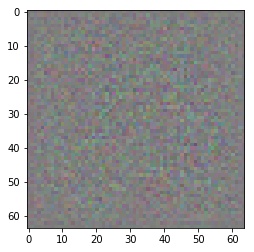

In [245]:
print_generator()

# Training part 

In [246]:
#We create our dataset
imagenet_data = torchvision.datasets.ImageFolder(root='/home/remi/Downloads/full',transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

In [247]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [248]:
def train(niter, first=True):
    train_generator = True
    gen_iterations = 0
    for epoch in range(niter):
        netD.train(); netG.train()
        data_iter = iter(data_loader)
        i,n = 0,len(data_loader)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.train()
                netG.eval()
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                i += 1
                if train_generator:
                    while (j < d_iters) and (i < n):
                        j += 1; i += 1
                        for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                        real = Variable(iter(data_loader).next()[0]).cuda()
                        real_loss = netD(real)
                        fake = netG(create_noise(real.size(0)))
                        fake_loss = netD(Variable(fake.data))
                        netD.zero_grad()
                        lossD = real_loss-fake_loss
                        lossD.backward()
                        optimizerD.step()
                        pbar.update()
                        
                pbar.update()
                netD.eval()
                netG.train()
                netG.zero_grad()
                lossG = netD(netG(create_noise(nz))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
                
        loss_G_list.append(lossG.data[0])        
        if train_generator:
            print(f'Epoch {epoch}: Loss_D {lossD.data[0]}; Loss_G {lossG.data[0]}; ' f'D_real {real_loss.data[0]}; Loss_D_fake {fake_loss.data[0]}')
            loss_D_list.append(lossD.data[0])

        else:
            print(f'Epoch {epoch}; Loss_G {lossG.data[0]}; ')


In [249]:
torch.backends.cudnn.benchmark=True

In [251]:
train(10, True)

  1%|          | 15/2369 [01:26<3:27:14,  5.28s/it]Process Process-13088:
Process Process-13087:
Process Process-13117:
Process Process-13115:
Traceback (most recent call last):
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-package

KeyboardInterrupt: 

  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 129, in pil_loader
    img = Image.open(f)
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 129, in pil_loader
    img = Image.open(f)
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/PIL/Image.py", line 2589, in open
    prefix = fp.read(16)
Traceback (most recent call last):
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-13116:
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/PIL/Image.py", line 2589, in open
    prefix = fp.read(16)
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/remi/anaconda3/envs/fast/lib/python3.6/site-packages/torch/uti

In [ ]:
list_print.append(print_generator())

In [ ]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [ ]:
train(10, False)

In [ ]:
plt.plot(loss_G_list)
plt.show()

In [ ]:
plt.plot(loss_D_list)#best result:-1.110
plt.show()

In [ ]:
print_generator()

In [ ]:
im =iter(data_loader).next()[0].numpy()[0]
im = np.swapaxes(im,0,1)
im = np.swapaxes(im,1,2)
      
imshow(im)